In [1]:
### Set CUDA device
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [2]:
import numpy as np
import torch
from torch import Tensor, nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import sys
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
from torchvision.transforms import GaussianBlur
from torchmetrics.functional.classification import dice
from sklearn.covariance import LedoitWolf

## Augmentations
from batchgenerators.transforms.noise_transforms import augment_gaussian_blur


sys.path.append('../')
from data_utils import get_eval_data
from model.unet import get_unet
from utils import  epoch_average, UMapGenerator
from model.mahalanobis_adatper import (
    get_pooling_mahalanobis_detector, 
    get_batchnorm_mahalanobis_detector
)
from model.wrapper import PoolingMahalanobisWrapper, BatchNormMahalanobisWrapper

# from losses import (
#     DiceScoreCalgary, 
#     DiceScoreMMS
# )

nnUNet_raw_data_base is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
RESULTS_FOLDER is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read documentation/setting_up_paths.md for information on how to set this up.


In [3]:
### Load basic config
cfg = OmegaConf.load('../configs/basic_config_venusberg.yaml')
OmegaConf.update(cfg, 'run.iteration', 0)

In [4]:
### Set dataset, either brain or heart
DATA_KEY = 'heart'
OmegaConf.update(cfg, 'run.data_key', DATA_KEY)


### get model
# available models:
#     - default-8
#     - default-16
#     - monai-8-4-4
#     - monai-16-4-4
#     - monai-16-4-8
#     - monai-32-4-4
#     - monai-64-4-4
#     - swinunetr


unet_name = 'default-8'
postfix = '_no-blurring'
args = unet_name.split('-')
cfg.unet[DATA_KEY].pre = unet_name + postfix
cfg.unet[DATA_KEY].arch = args[0]
cfg.unet[DATA_KEY].n_filters_init = int(args[1])

if args[0] == 'monai':
    cfg.unet[DATA_KEY].depth = int(args[2])
    cfg.unet[DATA_KEY].num_res_units = int(args[3])


unet, state_dict = get_unet(
    cfg,
    update_cfg_with_swivels=False,
    return_state_dict=True)
unet.load_state_dict(state_dict)
_ = unet.cuda()

In [5]:
# Set debug mode for only a small fraction of the datasets. Speeds up this cell by alot
cfg.debug = False

# update config with default values
OmegaConf.update(
    cfg, 
    'eval',
    OmegaConf.load('../configs/eval/unet_config.yaml')
)

# Wether and how you want to subset in case of Brain data. WARNING:
# After subsetting the eval below will not work with surface
# Dice anymore, because volumes are fragmented. 
APPLY_SUBSETTING = True
OmegaConf.update(cfg, 'eval.data.subset.apply', APPLY_SUBSETTING)
subset_params = {
    'n_cases': 256,  # selects at most so many cases
    'fraction': 0.1, # selects from the 10% worst cases w.r.t to a model
}
OmegaConf.update(
    cfg, 
    'eval.data.subset.params', 
    OmegaConf.create(subset_params)
)

if cfg.eval.data.subset.apply:
    subset_dict = OmegaConf.to_container(
        cfg.eval.data.subset.params, 
        resolve=True, 
        throw_on_missing=True
    )
    subset_dict['unet'] = unet
else:
    subset_dict = None

### select the datasets within the domain
# get training data
cfg.eval.data.training = True
# get validation data
cfg.eval.data.validation = False
# get testing data
# Options for Brain are any subset of [1, 2, 3, 4, 5] or 'all' 
# Options for Heart are any subset of ['A', 'B', 'C', 'D'] or 'all'
cfg.eval.data.testing = [] #'all'


data = get_eval_data(
    train_set=cfg.eval.data.training,
    val_set=cfg.eval.data.validation,
    test_sets=cfg.eval.data.testing,    
    cfg=cfg,
    subset_dict=subset_dict
)

print(f'\nAvailable datasets are: {list(data.keys())}')

loading dataset
loading all case properties

Available datasets are: ['train']


In [6]:
class DomainshiftAugmenter(nn.Module):
    def __init__(self, augments: List[nn.Module]):
        super(DomainshiftAugmenter, self).__init__()
        self.augments = augments
    
    def forward(self, x: Tensor):
        return [aug(x) for aug in self.augments]
    

def get_gaussian_domainshift_augments(
    sigmas: List[float],
    truncate: float = 4.0,
) -> List[nn.Module]:
    # radius = round(truncate * sigma)
    # kernel_size = 2*radius + 1

    return [
        GaussianBlur(
            kernel_size=2 * round(truncate * sigma) + 1,
            sigma=sigma
        ) for sigma in sigmas
    ]

augs = get_gaussian_domainshift_augments(
    sigmas=[0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
)

In [20]:
dataloader = DataLoader(data['train'], 
    batch_size=32, 
    shuffle=False, 
    drop_last=False
)

In [131]:

class UMapGenerator(nn.Module):
    """
    Calculates uncertainty maps from UNets in different ways.
    
    PyTorch Module to generate uncertainty maps from
    * VAE samples
    * Entropy in drop out samples
    * Entropy in model outputs
    """
    
    def __init__(
        self,
        method: str,  # 'ae'
        net_out: str,  # 'mms' or 'calgary'
    ):
        super().__init__()
        self.method  = method
        self.net_out = net_out
        self.m       = nn.Softmax(dim=1) if net_out=='heart' else nn.Sigmoid()
        self.ce      = nn.CrossEntropyLoss(reduction='none') if net_out=='heart' else nn.BCEWithLogitsLoss(reduction='none')
        self.kld     = nn.KLDivLoss(reduction='none')
        self.mse     = nn.MSELoss(reduction='none')
    
    @torch.no_grad()
    def forward(self, x: Tensor, batch_size: int = 1) -> Tensor:
        
        if self.method == 'none':
            return None
        
        x = x.detach()

        #################################
        ### Cross and regular Entropy ###
        #################################

        if self.method == 'cross_entropy':
            umap = self.ce(x[:batch_size], self.m(x[batch_size:]))
            if len(umap.shape) == 3:
                umap = umap.unsqueeze(1)
            # umap = umap.mean(dim=1, keepdims=True)
            
        elif self.method == 'entropy':          
            x_prob = self.m(x[:batch_size])
            umap = torch.special.entr(x_prob).sum(dim=1, keepdims=True)
            # umap = torch.distributions.Categorical(x_prob.permute(0,2,3,1)).entropy().unsqueeze(1)

        elif self.method == 'top2diff':
            x_prob = self.m(x[:batch_size])
            assert len(x_prob.shape) == 4, f"x_prob shape is {x_prob.shape}, but should be (n, c, h, w)"
            x_prob_sorted, _ = x_prob.sort(1)
            umap = 1 - (x_prob_sorted[:, -1:] - x_prob_sorted[:, -2:-1])
            assert len(umap.shape) == 4, f"umap shape is {umap.shape}, but should be (n, 1, h, w)"

        elif self.method == 'top2diff_diff':
            output_prob, output_augmented_prob = torch.split(self.m(x), batch_size)
            output_prob_sorted, _ = output_prob.sort(1)
            output_augmented_prob_sorted, _ = output_augmented_prob.sort(1)
            umap = (output_prob_sorted[:, -1:] - output_prob_sorted[:, -2:-1]) - \
                   (output_augmented_prob_sorted[:, -1:] - output_augmented_prob_sorted[:, -2:-1])

        elif self.method == 'kld_entr':
            output_prob, output_augmented_prob = torch.split(self.m(x), batch_size)
            output_augmented_log_prob = torch.log(output_augmented_prob + 1e7)
            # output_augmented_prob = self.m(x[batch_size:])
            entropy = torch.special.entr(output_prob).sum(dim=1, keepdims=True)
            # print(f'entropy: {entropy.shape} {entropy.mean()}')
            kld = self.kld(output_augmented_log_prob, output_prob).sum(dim=1, keepdims=True)
            # print(f'kld: {kld.shape} {kld.mean()}')
            umap = entropy * kld

        elif self.method == 'mse_entr':
            output_prob, output_augmented_prob = torch.split(self.m(x), batch_size)
            output_augmented_log_prob = torch.log(output_augmented_prob + 1e7)
            # output_augmented_prob = self.m(x[batch_size:])
            entropy = torch.special.entr(output_prob).sum(dim=1, keepdims=True)
            # print(f'entropy: {entropy.shape} {entropy.mean()}')
            mse = self.mse(output_prob, output_augmented_prob).mean(dim=1, keepdims=True)
            # print(f'kld: {kld.shape} {kld.mean()}')
            umap = entropy * mse

        elif self.method == 'centr_entr':
            output_prob, output_augmented_prob = torch.split(self.m(x), batch_size)
            entropy = torch.special.entr(output_prob).sum(dim=1, keepdims=True)
            ce = self.ce(output_prob, output_augmented_prob).unsqueeze(1)#.sum(dim=1, keepdims=True)
            umap = entropy * ce

        elif self.method == 'diff_grad':
            output_prob, output_augmented_prob = torch.split(self.m(x), batch_size)
            predicted_class_prob, index_of_class = output_prob.max(dim=1, keepdim=True)
            diff_to_pred = predicted_class_prob - output_prob
            diff_to_pred_augmented = torch.gather(output_augmented_prob, 1, index_of_class) - output_augmented_prob
            umap = (diff_to_pred - diff_to_pred_augmented) / torch.max(diff_to_pred, torch.ones_like(diff_to_pred) * 1e7)
            umap = torch.amax(umap, dim=1, keepdim=True)
        
        #################################
        ### experimental / M&M only   ###
        #################################
    
        elif self.method == 'kl_divergence':
            x_in = F.log_softmax(x[:batch_size], dim=1)
            umap = self.kl(x_in, self.m(x[batch_size:]))
            umap = umap.sum(dim=(1), keepdims=True)
            
        elif self.method == 'mse':
            x      = self.m(x)
            x     -= x.min(dim=1, keepdims=True).values
            x     /= x.sum(dim=1, keepdims=True)
            umap   = torch.pow(x[:batch_size] - x[batch_size:], 2).mean(1, keepdim=True)
            # umap   = umap.mean(dim=1, keepdims=True)            
            # print(umap.shape)
        #################################
        ###   old umaps from MICCAI   ###
        #################################
        
#         if self.method == 'ae':
#             if self.net_out == 'mms':                
#                 umap = self.ce(x[:1], self.m(x[1:]))
#                 #umap = umap.mean(dim=(0, 1), keepdims=True)
#                 #print(umap.shape)
#                 umap = umap.mean(dim=0, keepdims=True)
# #                 x      = self.m(x)
# #                 x     -= x.min(dim=1, keepdims=True).values
# #                 x     /= x.sum(dim=1, keepdims=True)
# #                 umap   = torch.pow(x[:1] - x[1:], 2).mean(0, keepdim=True)
# #                 umap   = umap.mean(dim=1, keepdims=True)
                
#             elif self.net_out == 'calgary':
#                 x    = torch.sigmoid(x)
#                 umap = torch.pow(x[:1] - x[1:], 2).mean(0, keepdim=True)
# #                 umap = self.ce(x[:1] - self.m(x[1:]))
# #                 umap = 
                
                
#         elif self.method == 'entropy':          

#             if self.net_out == 'mms':
#                 #print('x', x.shape)
#                 #x_argmax  = torch.argmax(x, dim=1)
#                 #print('2',x_argmax.shape)
#                 #x_one_hot = F.one_hot(x_argmax, num_classes=4).permute(0,3,1,2).float()
#                 #print('3',x_one_hot.shape)
#                 x_softmax = F.softmax(x, dim=1)
#                 #print('soft',x_softmax.shape)
#                 #x_mean    = x_one_hot.mean(dim=0, keepdims=True)
#                 x_mean    = x_softmax.mean(dim=0, keepdims=True)
#                 #print('4',x_mean.shape)
#                 umap = torch.distributions.Categorical(x_mean.permute(0,2,3,1)).entropy()
#                 #print('5',umap.shape)
#                 #umap      = - x_mean * torch.log(x_mean)
#                 #umap      = umap.sum(dim=1, keepdims=True)

#             elif self.net_out == 'calgary':
#                 x_probs = torch.sigmoid(x[1:])
#                 x_mean  = x_probs.mean(dim=0, keepdims=True)
#                 umap    = - x_mean * torch.log(x_mean) - (1-x_mean) * torch.log(1-x_mean)
                
#         elif self.method == 'probs':
#             if self.net_out == 'mms':
#                 x_probs = F.softmax(x, dim=1)
#                 umap = torch.distributions.Categorical(x_probs.permute(0,2,3,1)).entropy()
#                 #umap    = - x_probs * torch.log(x_probs)
#                 #umap    = umap.sum(dim=1, keepdims=True)
                
#             elif self.net_out == 'calgary':
#                 x_probs = torch.sigmoid(x)
#                 #print(x_probs.min(), x_probs.max())
#                 #umap = torch.distributions.Categorical(x_probs.permute(0,2,3,1)).entropy()
#                 umap    = - x_probs * torch.log(x_probs+1e-6) - (1-x_probs) * torch.log(1-x_probs+1e-6)
        
        assert umap.shape[1] == 1, f"umap shape is {umap.shape}, but should be (n, 1, h, w)"
        assert not torch.isnan(umap).any(), f"umap contains nan values"
        return umap

In [132]:
device = ['cuda:0', 'cpu']
umap = 'top2diff_diff'
net_out = 'heart'


umap_generator = UMapGenerator(
    method=umap,
    net_out=net_out,
).to(device[0])

In [188]:

class PoolingMahalanobisDetector(nn.Module):
    def __init__(
        self,
        swivel: str,
        pool: str = 'avg2d',
        sigma_algorithm: str = 'default',
        transform: bool = False,
        lr: float = 1e-3,
        device: str  = 'cuda:0'
    ):
        super().__init__()
        # init args
        self.swivel = swivel
        self.pool = pool
        self.sigma_algorithm = sigma_algorithm
        # self.hook_fn = self.register_forward_pre_hook if hook_fn == 'pre' else self.register_forward_hook
        self.transform = transform
        self.lr = lr
        self.device = device
        # other attributes
        self.training_representations = []
        # methods
        if self.pool == 'avg2d':
            self._pool = nn.AvgPool2d(
                kernel_size=(2,2), 
                stride=(2,2)
            )
        elif self.pool == 'avg3d':
            self._pool = nn.AvgPool3d(
                kernel_size=(2,2,2),
                stride=(2,2,2)
            )
        self.to(device)


    ### private methods ###

    def _reduce(self, x: Tensor) -> Tensor:
        if 'avg' in self.pool:
            # reduce dimensionality with 3D pooling to below 1e4 entries
            while torch.prod(torch.tensor(x.shape[1:])) > 1e4:
                x = self._pool(x)
            x = self._pool(x)
        elif self.pool == 'none':
            pass
        # reshape to (batch_size, 1, n_features)
        x = x.reshape(x.shape[0], 1, -1)
        return x


    @torch.no_grad()
    def _collect(self, x: Tensor) -> None:
        # reduces dimensionality, moves to cpu and stores
        
        x = self._reduce(x.detach()).cpu()
        self.training_representations.append(x)


    @torch.no_grad()
    def _merge(self) -> None:
        # concatenate batches from training data
        self.training_representations = torch.cat(
            self.training_representations,
            dim=0
        )


    @torch.no_grad()
    def _estimate_gaussians(self) -> None:
        self.register_buffer(
            'mu',
            self.training_representations.mean(0, keepdims=True).detach().to(self.device)
        )
        
        if self.sigma_algorithm == 'diagonal':
            self.register_buffer(
                'var',
                torch.var(self.training_representations.squeeze(1), dim=0).detach()
            )
            self.register_buffer(
                'sigma_inv', 
                1 / torch.sqrt(self.var).detach().to(self.device)
            )
        
        elif self.sigma_algorithm == 'default':
            self.register_buffer(
                'sigma',
                torch.cov(self.training_representations.squeeze(1).T)
            )
            self.register_buffer(
                'sigma_inv', 
                torch.linalg.inv(self.sigma).detach().unsqueeze(0).to(self.device)
            )

        elif self.sigma_algorithm == 'ledoitWolf':
            self.register_buffer(
                'sigma', 
                torch.from_numpy(
                    LedoitWolf().fit(
                        self.training_representations.squeeze(1)
                    ).covariance_
                )
            )
            self.register_buffer(
                'sigma_inv', 
                torch.linalg.inv(self.sigma).detach().unsqueeze(0).to(self.device)
            )

        else:
            raise NotImplementedError('Choose from: lediotWolf, diagonal, default')



    def _distance(self, x: Tensor) -> Tensor:
        assert self.sigma_inv is not None, 'fit the model first'
        x_reduced  = self._reduce(x)
        x_centered = x_reduced - self.mu
        if self.sigma_algorithm == 'diagonal':
            dist  = x_centered**2 * self.sigma_inv
            dist = dist.sum(1)
        else:
            dist = x_centered @ self.sigma_inv @ x_centered.permute(0,2,1)

        return torch.sqrt(dist)


    ### public methods ###

    def fit(self):
        self._merge()
        self._estimate_gaussians()
        del self.training_representations


    def forward(self, x: Tensor) -> Tensor:
        # implements identity function from a hooks perspective
        if self.training:
            self._collect(x)
        
        else:
            self.batch_distances = self._distance(x).detach().view(-1)
            if self.transform:
                x = x.clone().detach().requires_grad_(True)
                dist_tmp = self._distance(x)
                dist = dist_tmp.sum()
                dist.backward()
                x.grad.data = torch.nan_to_num(x.grad.data, nan=0.0)
                x.data.sub_(self.lr * x.grad.data)
                x.grad.data.zero_()
                x.requires_grad = False

        return x


def get_pooling_mahalanobis_detector(
    swivels: List[str],
    unet: nn.Module = None,
    pool: str = 'avg2d',
    sigma_algorithm: str = 'default',
    fit: str  = 'raw', # None, 'raw', 'augmented'
    iid_data: DataLoader = None,
    transform: bool = False,
    lr: float = 1e-3,
    device: str  = 'cuda:0',
): 

    pooling_detector = [
        PoolingMahalanobisDetector(
            swivel=swivel,
            device=device,
            pool=pool,
            sigma_algorithm=sigma_algorithm,
            transform=transform,
            lr=lr,
        ) for swivel in swivels
    ]
    pooling_wrapper = PoolingMahalanobisWrapper(
        model=unet,
        adapters=nn.ModuleList(pooling_detector)
    )
    pooling_wrapper.hook_adapters()
    pooling_wrapper.to(device)
    if fit == 'raw':
        for batch in iid_data:
            x = batch['input'].to(device)
            _ = pooling_wrapper(x)
    elif fit == 'augmented':
        for _ in range(250):
            batch = next(iid_data)
            x = batch['data'].to(device)
            _ = pooling_wrapper(x)
    if fit is not None:
        pooling_wrapper.fit()
        pooling_wrapper.eval()

    return pooling_wrapper

In [189]:
swivels = [layer[0] for layer in unet.named_modules() if 'bn' in layer[0]]

# swivels=['up3.0.conv_path.0.bn']

mahalanobis_detector = get_pooling_mahalanobis_detector(
    swivels=swivels,
    unet=unet,
    pool='none',
    sigma_algorithm='diagonal',
    fit='raw',
    iid_data=dataloader,
    transform=True,
    lr=1e4,
    device='cuda:0'
)

In [228]:
from matplotlib.colors import ListedColormap, Normalize

def format_e(n):
    a = '%e' % n
    return a.split('e')[0].rstrip('0').rstrip('.') + 'e' + a.split('e')[1]


# Create a custom colormap - transparent for class 0, and different colors for other classes
seg_colors = ['none', 'yellow', 'green', 'blue']  # 'none' for transparent
err_colors = ['none', 'red']
seg_cmap = ListedColormap(seg_colors)
err_cmap = ListedColormap(err_colors)

# Ensure the colormap is normalized to the number of classes
seg_norm = Normalize(vmin=0, vmax=len(seg_colors)-1)
err_norm = Normalize(vmin=0, vmax=len(err_colors)-1)

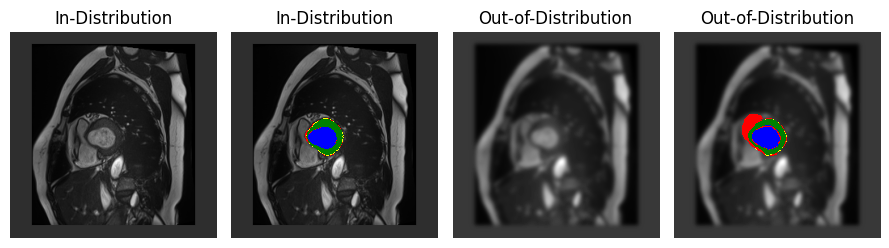

In [231]:
idx = 30
# mahalanobis_detector.set_lr(lr)

n_plots = 4
fig, axes = plt.subplots(1, n_plots, figsize=(n_plots + 5, 5))


data_sample = data['train'][idx]
x_in, target = [d.unsqueeze(0) for d in list(data_sample.values())[:2]]
target[target == -1] = 0
x_in_aug = augs[4](x_in).to(device[0])

mahalanobis_detector.set_transform(False)
output_id  = mahalanobis_detector(x_in.to(device[0])).detach().cpu()
segment_id = torch.argmax(output_id, dim=1).squeeze()
error_id = (segment_id != target).squeeze()

output_ood = mahalanobis_detector(x_in_aug).detach().cpu()
segmend_ood = torch.argmax(output_ood, dim=1).squeeze()
error_ood = (segmend_ood != target).squeeze()

# axes[0].imshow(error_id, cmap='bwr')

axes[0].imshow(x_in.detach().cpu().squeeze(), cmap='gray')
axes[0].set_title('In-Distribution')


axes[1].imshow(x_in.detach().cpu().squeeze(), cmap='gray')
axes[1].imshow(segment_id, cmap=seg_cmap, norm=seg_norm)
axes[1].imshow(error_id, cmap=err_cmap, norm=err_norm)
axes[1].set_title('In-Distribution')
# axes[1].imshow(error_ood, cmap='bwr')

axes[2].imshow(x_in_aug.detach().cpu().squeeze(), cmap='gray')
axes[2].set_title('Out-of-Distribution')


axes[3].imshow(x_in_aug.detach().cpu().squeeze(), cmap='gray')
axes[3].imshow(segmend_ood, cmap=seg_cmap, norm=seg_norm)
axes[3].imshow(error_ood, cmap=err_cmap, norm=err_norm)
axes[3].set_title('Out-of-Distribution')


# mahalanobis_detector.set_transform(True)
# for i, lr in enumerate(lrs):
#     mahalanobis_detector.set_lr(lr)
#     output_ood_transformed = mahalanobis_detector(x_in_aug).detach().cpu()
#     segment_ood_transformed = torch.argmax(output_ood_transformed, dim=1).squeeze()
#     error_ood_transformed = (segment_ood_transformed != target).squeeze()
#     # axes[i+2].imshow(error_ood_transformed, cmap='bwr')
#     axes[i+2].imshow(x_in_aug.detach().cpu().squeeze(), cmap='gray')
#     axes[i+2].imshow(segment_ood_transformed, cmap=seg_cmap, norm=seg_norm)
#     axes[i+2].imshow(error_ood_transformed, cmap=err_cmap, norm=err_norm)
#     axes[i+2].set_title(f'{format_e(lr)}')


for ax in axes.ravel():
    ax.set_axis_off()
plt.tight_layout()

# fig.savefig(f'../../results/example_22-4-24.jpg', bbox_inches='tight')

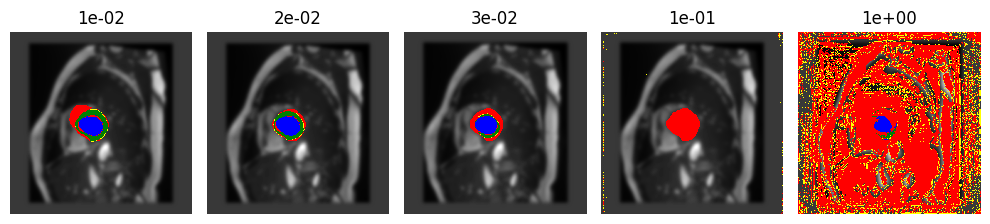

In [232]:

lrs = torch.tensor([1e-2, 2e-2, 3e-2, 1e-1, 1e0])
# lrs /= (32**3 * 2)
n_plots = len(lrs)
fig, axes = plt.subplots(1, n_plots, figsize=(n_plots + 5, 5))

mahalanobis_detector.set_transform(True)
for i, lr in enumerate(lrs):
    mahalanobis_detector.set_lr(lr)
    output_ood_transformed = mahalanobis_detector(x_in_aug).detach().cpu()
    segment_ood_transformed = torch.argmax(output_ood_transformed, dim=1).squeeze()
    error_ood_transformed = (segment_ood_transformed != target).squeeze()
    # axes[i+2].imshow(error_ood_transformed, cmap='bwr')
    axes[i].imshow(x_in_aug.detach().cpu().squeeze(), cmap='gray')
    axes[i].imshow(segment_ood_transformed, cmap=seg_cmap, norm=seg_norm)
    axes[i].imshow(error_ood_transformed, cmap=err_cmap, norm=err_norm)
    axes[i].set_title(f'{format_e(lr)}')


for ax in axes.ravel():
    ax.set_axis_off()
plt.tight_layout()

fig.savefig(f'../../results/LR_22-4-24.jpg', bbox_inches='tight')

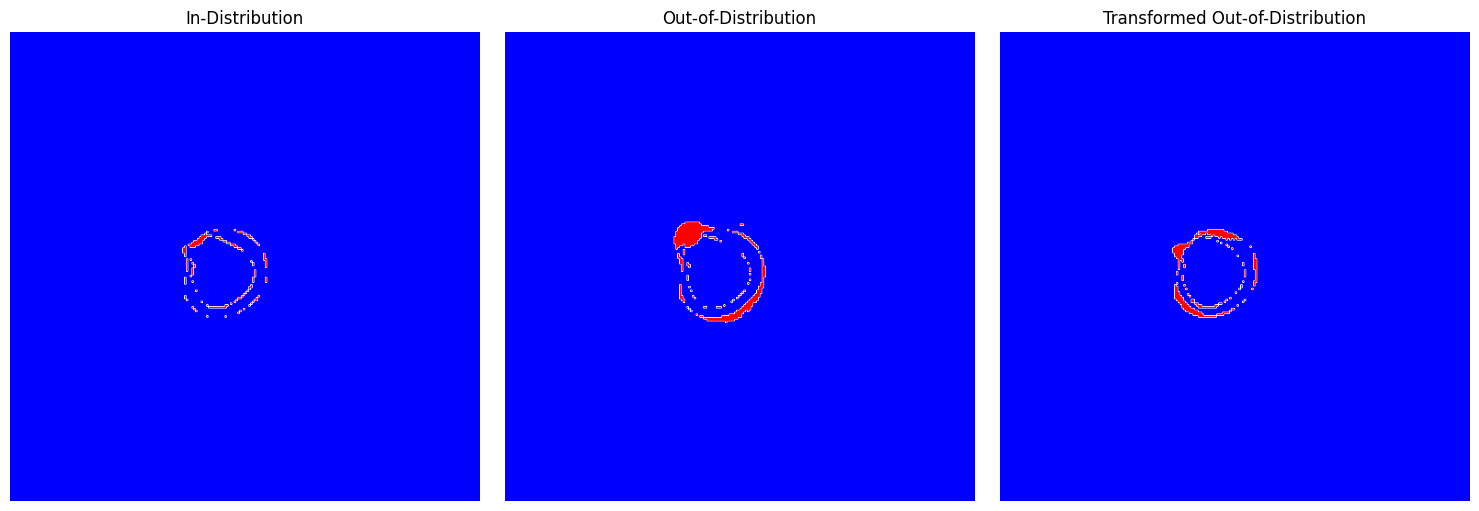

In [74]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(error_id, cmap='bwr')
axes[0].set_title('In-Distribution')
axes[1].imshow(error_ood, cmap='bwr')
axes[1].set_title('Out-of-Distribution')
axes[2].imshow(error_ood_transformed, cmap='bwr')
axes[2].set_title('Transformed Out-of-Distribution')

for ax in axes.ravel():
    ax.set_axis_off()
plt.tight_layout()

In [68]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(torch.argmax(output_id[0], 0).numpy())
axes[0].set_title('In-Distribution')
axes[1].imshow(torch.argmax(output_ood[0], 0).numpy())
axes[1].set_title('Out-of-Distribution')
axes[2].imshow(torch.argmax(output_ood_transformed[0], 0).numpy())
axes[2].set_title('Transformed Out-of-Distribution')

for ax in axes.ravel():
    ax.set_axis_off()
plt.tight_layout()

torch.Size([256, 256])

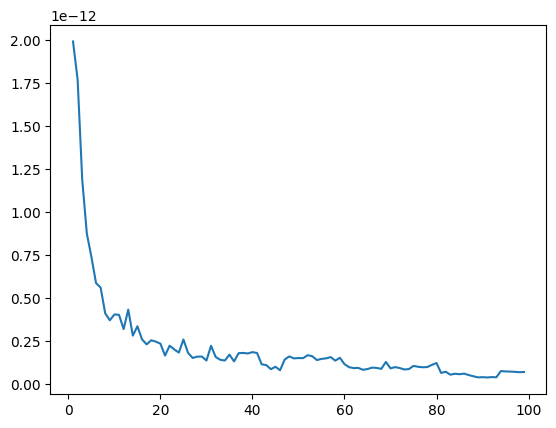

In [ ]:
plt.plot(scores)

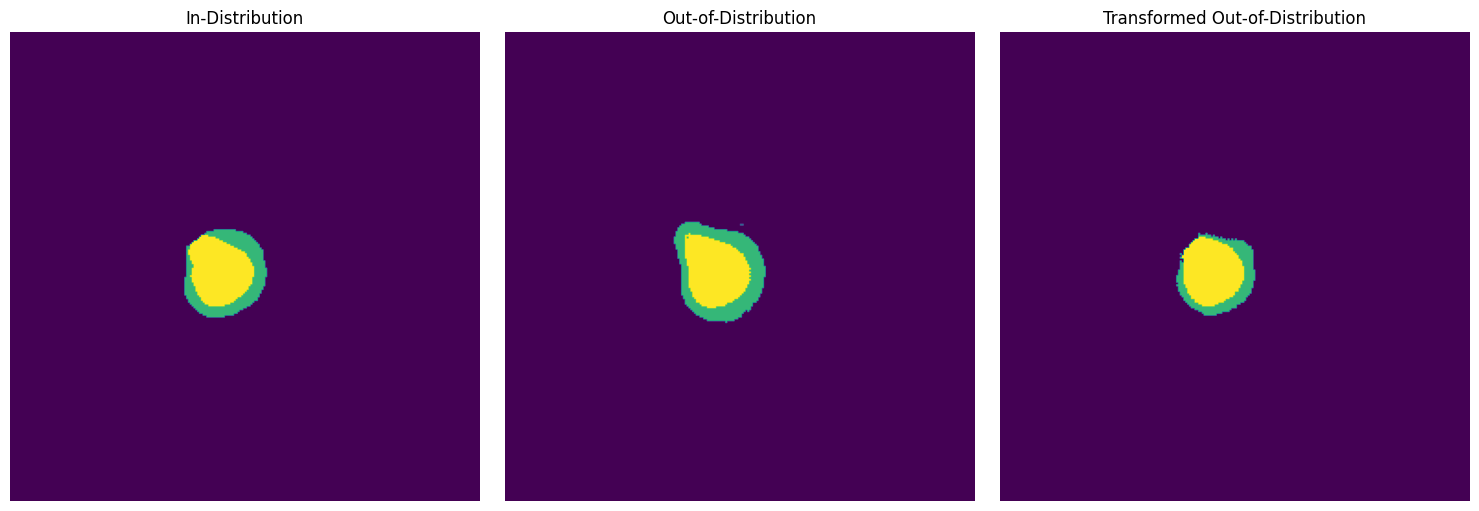

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(torch.argmax(output_id[0], 0).numpy())
axes[0].set_title('In-Distribution')
axes[1].imshow(torch.argmax(output_ood[0], 0).numpy())
axes[1].set_title('Out-of-Distribution')
axes[2].imshow(torch.argmax(output_ood_transformed[0], 0).numpy())
axes[2].set_title('Transformed Out-of-Distribution')

for ax in axes.ravel():
    ax.set_axis_off()
plt.tight_layout()

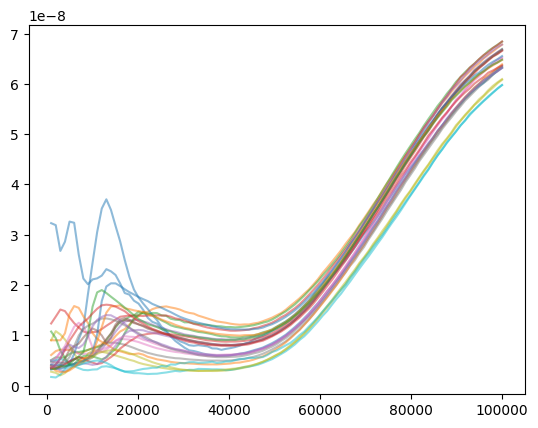

In [153]:
device = ['cuda:0', 'cpu']
umap = 'diff_grad'
net_out = 'heart'


umap_generator = UMapGenerator(
    method=umap,
    net_out=net_out,
).to(device[0])

idxs = [30, 40, 50]

for idx in range(25):
# idx = 40
# mahalanobis_detector.set_lr(lr)

    data_sample = data['train'][idx]
    x_in, target = [d.unsqueeze(0) for d in list(data_sample.values())[:2]]
    target[target == -1] = 0
    x_in_aug = augs[4](x_in).to(device[0])


    scores = []
    value_range = torch.linspace(0, 1e5, 100)
    mahalanobis_detector.set_transform(False)
    output_ood = mahalanobis_detector(x_in_aug).detach().cpu()
    mahalanobis_detector.set_transform(True)

    for lr in value_range:
        mahalanobis_detector.set_lr(lr)
        output_ood_transformed = mahalanobis_detector(x_in_aug).detach().cpu()
        umap_in = torch.cat([output_ood, output_ood_transformed], dim=0)
        umap = umap_generator(
            umap_in,
            batch_size=output_ood.shape[0]
        ).flatten()
        score = umap.sum() / lr
        scores.append(score)


    plt.plot(value_range, scores, label=f'{idx}', alpha=0.5)
# plt.legend()

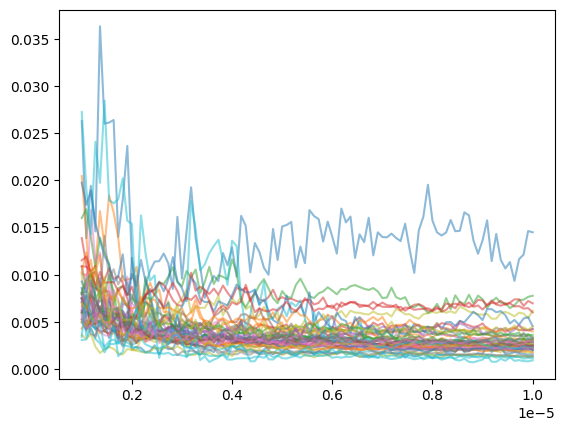

In [217]:
device = ['cuda:0', 'cpu']
# umap = 'top2diff_diff'
umap = 'diff_grad'
# umap='cross_entropy'
net_out = 'heart'


umap_generator = UMapGenerator(
    method=umap,
    net_out=net_out,
).to(device[0])

# idxs = [i for i in range(50)]
idxs = [i for i in range(50)]
# idx = 40
# mahalanobis_detector.set_lr(lr)

data_sample = data['train'][idxs]
x_in = data_sample['input']
target = data_sample['target']
target[target == -1] = 0
x_in_aug = augs[4](x_in).to(device[0])

scores = []
value_range = torch.linspace(1e-6, 1e-5, 100)
mahalanobis_detector.set_transform(False)
output_ood = mahalanobis_detector(x_in_aug).detach().cpu()
mahalanobis_detector.set_transform(True)

for lr in value_range:
    mahalanobis_detector.set_lr(lr)
    output_ood_transformed = mahalanobis_detector(x_in_aug).detach().cpu()
    umap_in = torch.cat([output_ood, output_ood_transformed], dim=0)
    umap = umap_generator(
        umap_in,
        batch_size=output_ood.shape[0]
    )
    # print(umap.shape)
    # print(umap.sum((1,2,3)) / lr)
    score = umap.sum((1,2,3)) / lr
    scores.append(score)

scores = torch.stack(scores, dim=0)
plt.plot(value_range, scores, label=f'{idx}', alpha=0.5)
plt.show()

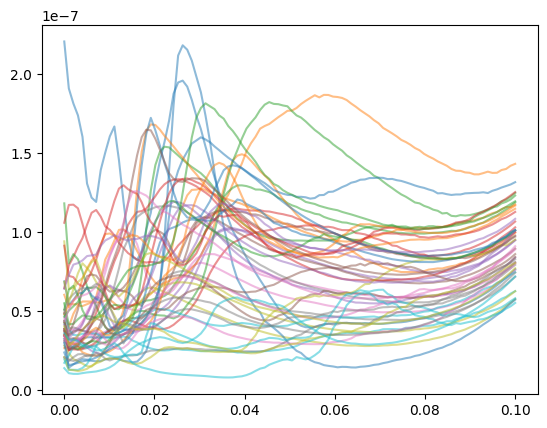

In [215]:
device = ['cuda:0', 'cpu']
# umap = 'top2diff_diff'
umap = 'diff_grad'
# umap='cross_entropy'
net_out = 'heart'


umap_generator = UMapGenerator(
    method=umap,
    net_out=net_out,
).to(device[0])

idxs = [i for i in range(50)]
# idxs = [40]
# idx = 40
# mahalanobis_detector.set_lr(lr)

data_sample = data['train'][idxs]
x_in = data_sample['input']
target = data_sample['target']
target[target == -1] = 0
x_in_aug = augs[4](x_in).to(device[0])

scores = []
value_range = torch.linspace(1e-5, 1e-1, 100)
mahalanobis_detector.set_transform(False)
output_ood = mahalanobis_detector(x_in_aug).detach().cpu()
mahalanobis_detector.set_transform(True)

for lr in value_range:
    mahalanobis_detector.set_lr(lr)
    output_ood_transformed = mahalanobis_detector(x_in_aug).detach().cpu()
    umap_in = torch.cat([output_ood, output_ood_transformed], dim=0)
    umap = umap_generator(
        umap_in,
        batch_size=output_ood.shape[0]
    )
    # print(umap.sum((1,2,3)) / lr)
    score = umap.mean((1,2,3)) / lr
    scores.append(score)

scores = torch.stack(scores, dim=0)
plt.plot(value_range, scores, label=f'{idx}', alpha=0.5)
plt.show()

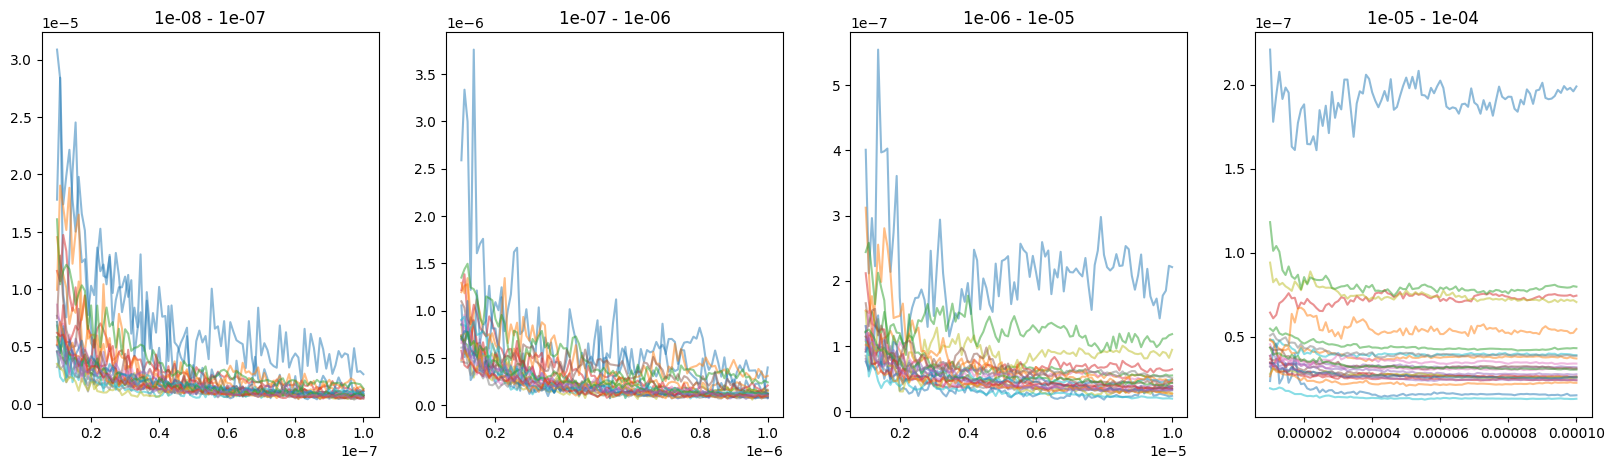

In [233]:
device = ['cuda:0', 'cpu']
# umap = 'top2diff_diff'
umap = 'diff_grad'
# umap='cross_entropy'
net_out = 'heart'


umap_generator = UMapGenerator(
    method=umap,
    net_out=net_out,
).to(device[0])

idxs = [i for i in range(25)]
# idxs = [40]
# idx = 40
# mahalanobis_detector.set_lr(lr)

data_sample = data['train'][idxs]
x_in = data_sample['input']
target = data_sample['target']
target[target == -1] = 0
x_in_aug = augs[4](x_in).to(device[0])

scores = []
value_range = torch.linspace(1e-5, 1e-1, 100)
mahalanobis_detector.set_transform(False)
output_ood = mahalanobis_detector(x_in_aug).detach().cpu()
mahalanobis_detector.set_transform(True)


lr_ranges = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4]

n_plots = len(lr_ranges) - 1
plot_size = 5

fig, axes = plt.subplots(1, n_plots, figsize=(n_plots * plot_size, plot_size))

for i in range(len(lr_ranges)-1):
    scores = []
    lr_start = lr_ranges[i]
    lr_stop  = lr_ranges[i+1]
    value_range = torch.linspace(lr_start, lr_stop, 100)
    for lr in value_range:
        mahalanobis_detector.set_lr(lr)
        output_ood_transformed = mahalanobis_detector(x_in_aug).detach().cpu()
        umap_in = torch.cat([output_ood, output_ood_transformed], dim=0)
        umap = umap_generator(
            umap_in,
            batch_size=output_ood.shape[0]
        )
        # print(umap.sum((1,2,3)) / lr)
        score = umap.mean((1,2,3)) / lr
        scores.append(score)
    scores = torch.stack(scores, dim=0)
    axes[i].plot(
        value_range, 
        scores,
        alpha=0.5

    )
    axes[i].title.set_text(f'{format_e(lr_start)} - {format_e(lr_stop)}')

fig.savefig(f'../../results/linearity-top_22-4-24.jpg', bbox_inches='tight')

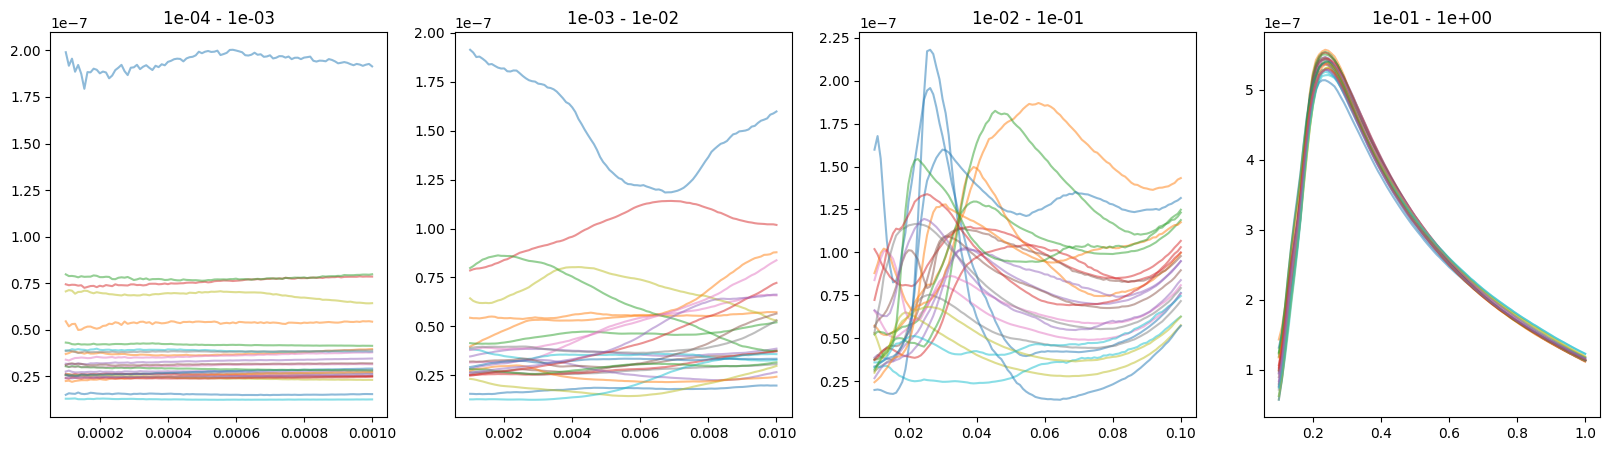

In [234]:
device = ['cuda:0', 'cpu']
# umap = 'top2diff_diff'
umap = 'diff_grad'
# umap='cross_entropy'
net_out = 'heart'


umap_generator = UMapGenerator(
    method=umap,
    net_out=net_out,
).to(device[0])

idxs = [i for i in range(25)]
# idxs = [40]
# idx = 40
# mahalanobis_detector.set_lr(lr)

data_sample = data['train'][idxs]
x_in = data_sample['input']
target = data_sample['target']
target[target == -1] = 0
x_in_aug = augs[4](x_in).to(device[0])

scores = []
value_range = torch.linspace(1e-5, 1e-1, 100)
mahalanobis_detector.set_transform(False)
output_ood = mahalanobis_detector(x_in_aug).detach().cpu()
mahalanobis_detector.set_transform(True)


lr_ranges = [1e-4, 1e-3, 1e-2, 1e-1, 1e0]
n_plots = len(lr_ranges) - 1
plot_size = 5

fig, axes = plt.subplots(1, n_plots, figsize=(n_plots * plot_size, plot_size))

for i in range(len(lr_ranges)-1):
    scores = []
    lr_start = lr_ranges[i]
    lr_stop  = lr_ranges[i+1]
    value_range = torch.linspace(lr_start, lr_stop, 100)
    for lr in value_range:
        mahalanobis_detector.set_lr(lr)
        output_ood_transformed = mahalanobis_detector(x_in_aug).detach().cpu()
        umap_in = torch.cat([output_ood, output_ood_transformed], dim=0)
        umap = umap_generator(
            umap_in,
            batch_size=output_ood.shape[0]
        )

        score = umap.mean((1,2,3)) / lr
        scores.append(score)
    scores = torch.stack(scores, dim=0)
    axes[i].plot(
        value_range, 
        scores,
        alpha=0.5

    )
    axes[i].title.set_text(f'{format_e(lr_start)} - {format_e(lr_stop)}')

# fig.savefig(f'../../results/linearity-bot_22-4-24.jpg', bbox_inches='tight')

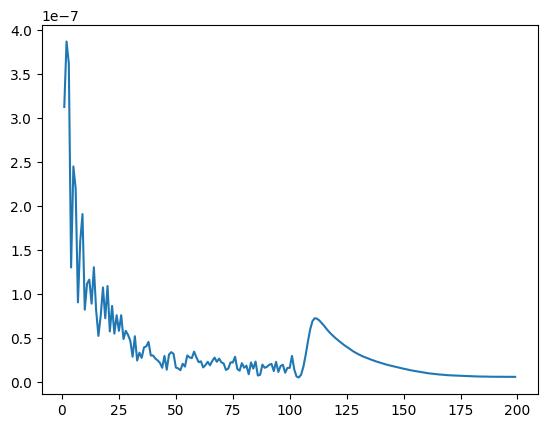

In [50]:
scores = []

value_range = torch.linspace(0, 1, 99)

for lr in value_range:
    mahalanobis_detector.set_lr(lr)
    mahalanobis_detector.set_transform(False)
    output_ood = mahalanobis_detector(x_in_aug).detach().cpu()
    mahalanobis_detector.set_transform(True)
    output_ood_transformed = mahalanobis_detector(x_in_aug).detach().cpu()
    umap_in = torch.cat([output_ood, output_ood_transformed], dim=0)
    umap = umap_generator(
        umap_in,
        batch_size=output_ood.shape[0]
    ).flatten()
    score = umap.sum() / lr

    scores.append(score)

# scores = []
value_range = torch.linspace(1, 1e6 + 1, 100)

for lr in value_range:
    mahalanobis_detector.set_lr(lr)
    mahalanobis_detector.set_transform(False)
    output_ood = mahalanobis_detector(x_in_aug).detach().cpu()
    mahalanobis_detector.set_transform(True)
    output_ood_transformed = mahalanobis_detector(x_in_aug).detach().cpu()
    umap_in = torch.cat([output_ood, output_ood_transformed], dim=0)
    umap = umap_generator(
        umap_in,
        batch_size=output_ood.shape[0]
    ).flatten()
    score = umap.sum() / lr
    scores.append(score)


plt.plot(scores)

([<matplotlib.axis.XTick at 0x7fca72f2ee30>,
 [Text(0.0, 0, '0.0'),
  Text(0.005050505045801401, 0, '0.010204081423580647'),
  Text(0.010101010091602802, 0, '0.020408162847161293'),
  Text(0.01515151560306549, 0, '0.030612245202064514'),
  Text(0.020202020183205605, 0, '0.040816325694322586'),
  Text(0.02525252476334572, 0, '0.05102040618658066'),
  Text(0.03030303120613098, 0, '0.06122449040412903'),
  Text(0.035353533923625946, 0, '0.0714285671710968'),
  Text(0.04040404036641121, 0, '0.08163265138864517'),
  Text(0.04545454680919647, 0, '0.09183673560619354'),
  Text(0.05050504952669144, 0, '0.10204081237316132'),
  Text(0.0555555559694767, 0, '0.11224489659070969'),
  Text(0.06060606241226196, 0, '0.12244898080825806'),
  Text(0.06565656512975693, 0, '0.13265305757522583'),
  Text(0.07070706784725189, 0, '0.1428571343421936'),
  Text(0.07575757801532745, 0, '0.15306122601032257'),
  Text(0.08080808073282242, 0, '0.16326530277729034'),
  Text(0.08585858345031738, 0, '0.1734693795442

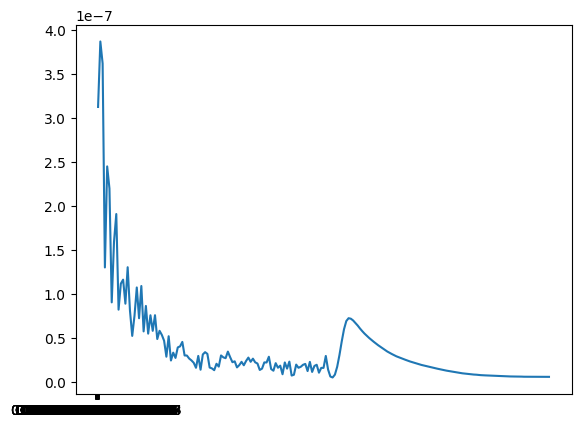

In [53]:

plt.plot(scores)
plt.xticks(
    ticks=torch.linspace(0, 1, 199),
    labels = torch.linspace(0, 1, 99).tolist() + torch.linspace(1, 1e6 + 1, 100).tolist()
)